In [5]:
import numpy as np

import matplotlib.pyplot as plt


from paiskintonetools import setup_matplotlib

import patato as pat

from scipy.sparse import load_npz
from scipy.signal import butter, filtfilt

from patato.recon.fourier_transform_rec import FFTReconstruction

plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlesize"] = "large"
plt.rcParams["axes.labelweight"] = "bold"
setup_matplotlib(dpi=200)

Make some mini figures for illustrative purposes:

In [8]:
# N.b. the model is too large to distribute on GitHub. Download from the data repository and adjust this.
m = load_npz(r"../../PAISKINTONE_DataDeposit/forward_model.npz")

In [9]:
examples_ita_max = [
    "Output/SKIN31/Scan_2_images.npy",
    "../Data/SKIN31/Scan_2.hdf5",
]

C:\Users\tomelse\AppData\Local\Temp\ipykernel_19316\3530705498.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


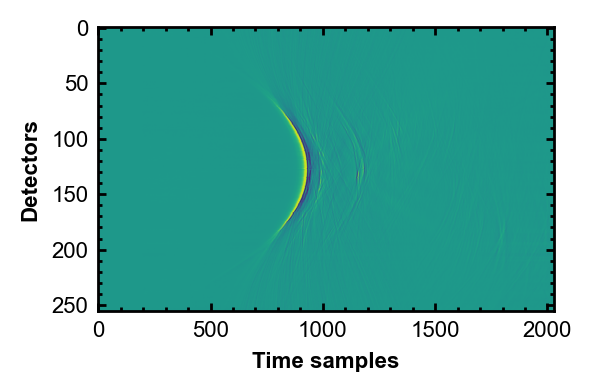

In [10]:
pa = pat.PAData.from_hdf5(examples_ita_max[1])
ts = pa.get_time_series()

ts_raw_data = np.squeeze(ts.raw_data[0, 0]) / pa.get_overall_correction_factor()[0, 0]

b, a = butter(5, [5e3, 7e6], btype="bandpass", fs=4e7)
ts_filtered = filtfilt(
    b, a, ts_raw_data, axis=-1, padtype="even", padlen=100, method="pad"
)
ts_filtered[:, :200] = 0

fig = plt.figure(figsize=(3, 2))
plt.imshow(ts_filtered, aspect="auto")
plt.xlabel("Time samples")
plt.ylabel("Detectors")
plt.tight_layout()
plt.savefig("Illustration Figures/timeseries.png", dpi=300)
plt.savefig("Illustration Figures/timeseries.svg", dpi=300)
plt.show()

C:\Users\tomelse\AppData\Local\Temp\ipykernel_19316\3724453961.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


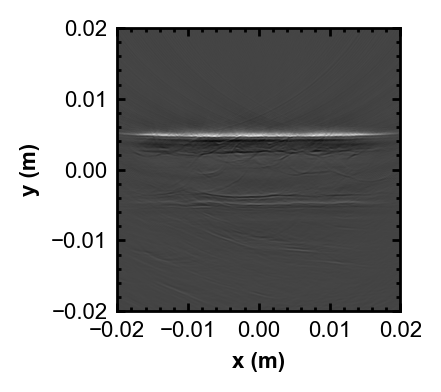

In [11]:
fig = plt.figure(figsize=(3, 2))
rec = pa.get_scan_reconstructions()["Model Based", "0"]
plt.imshow(
    np.squeeze(rec.raw_data[0, 0]), extent=rec.extent, origin="lower", cmap="gray"
)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.tight_layout()
plt.savefig("Illustration Figures/rec.png", dpi=300)
plt.savefig("Illustration Figures/rec.svg", dpi=300)
plt.show()

C:\Users\tomelse\AppData\Local\Temp\ipykernel_19316\2085285413.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


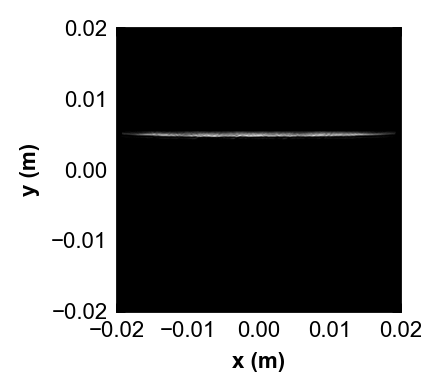

In [12]:
fig = plt.figure(figsize=(3, 2))
rec = pa.get_scan_reconstructions()["Model Based", "0"]
roi = pa.get_rois()["skin_", "0"]
roi_mask, _ = roi.to_mask_slice(rec)
roi_mask &= rec.raw_data[0, 0] > 0
plt.imshow(
    np.squeeze(rec.raw_data[0, 0] * roi_mask),
    extent=rec.extent,
    origin="lower",
    cmap="gray",
)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.tight_layout()
plt.savefig("Illustration Figures/rec_masked.png", dpi=300)
plt.savefig("Illustration Figures/rec_masked.svg", dpi=300)

plt.show()

C:\Users\tomelse\AppData\Local\Temp\ipykernel_19316\3325871733.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


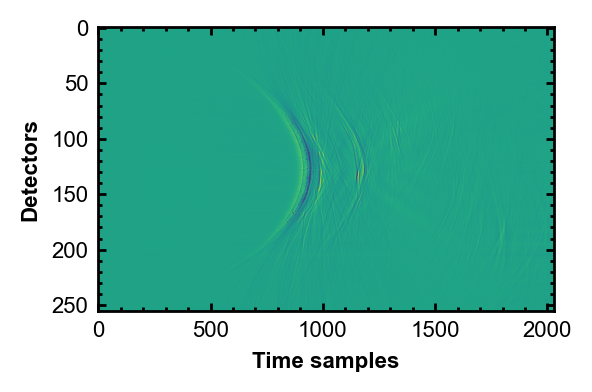

In [13]:
ts = pa.get_time_series()

ts_raw_data = np.squeeze(ts.raw_data[0, 0]) / pa.get_overall_correction_factor()[0, 0]

b, a = butter(5, [5e3, 7e6], btype="bandpass", fs=4e7)
ts_filtered = filtfilt(
    b, a, ts_raw_data, axis=-1, padtype="even", padlen=100, method="pad"
)
ts_filtered[:, :200] = 0

ts_filtered -= (m @ (rec.raw_data[0, 0] * roi_mask).ravel()).reshape((256, 2030))

fig = plt.figure(figsize=(3, 2))
plt.imshow(ts_filtered, aspect="auto")
plt.xlabel("Time samples")
plt.ylabel("Detectors")
plt.tight_layout()
plt.savefig("Illustration Figures/timeseries_processed.png", dpi=300)
plt.savefig("Illustration Figures/timeseries_processed.svg", dpi=300)

plt.show()

In [14]:
fft_rec = FFTReconstruction(field_of_view=(0.04, 0, 0.04), n_pixels=(400, 1, 400))
fft_rec.hankels = None

In [15]:
test, ft, k = fft_rec._reconstruct(
    ts_filtered,
    pa.get_sampling_frequency(),
    pa.get_scan_geometry(),
    (400, 1, 400),
    (0.04, 0, 0.04),
    1520,
    return_ft=True,
    debug=False,
)

In [16]:
from pa_to_us import reconstruct_plane_wave_us, ft_to_image

In [17]:
us_fft, us_image_recon = reconstruct_plane_wave_us(ft, 0.00474, 0.04 / 399, True)

In [18]:
us_fft_correct = us_fft

In [19]:
us_image = ft_to_image(us_fft_correct)[1600:2000, 400:800]
# Weight and apply log compression
weighting = np.exp(np.arange(400) / 75)
to_display = np.abs(us_image * weighting[:, None])
to_display = np.log10(1 + 3 * to_display) / np.log10(4)

C:\Users\tomelse\AppData\Local\Temp\ipykernel_19316\518576398.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


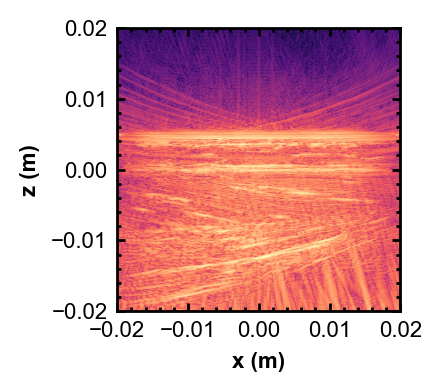

In [20]:
fig = plt.figure(figsize=(3, 2))
plt.imshow(np.flipud(to_display), extent=rec.extent, origin="lower", cmap="magma")
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.tight_layout()
plt.savefig("Illustration Figures/pw_us.png", dpi=300)
plt.savefig("Illustration Figures/pw_us.svg", dpi=300)
plt.show()

C:\Users\tomelse\AppData\Local\Temp\ipykernel_19316\1500141726.py:3: RuntimeWarning: divide by zero encountered in log
  np.log(np.abs(us_fft_correct)), origin="lower", cmap="viridis", extent=(-5, 5) * 2
C:\Users\tomelse\AppData\Local\Temp\ipykernel_19316\1500141726.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


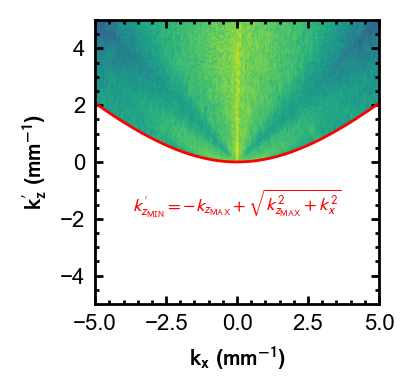

In [21]:
fig = plt.figure(figsize=(3, 2))
plt.imshow(
    np.log(np.abs(us_fft_correct)), origin="lower", cmap="viridis", extent=(-5, 5) * 2
)
plt.xlabel(r"$\mathbf{k_x}$ ($\mathbf{mm^{-1}}$)")
plt.ylabel(r"$\mathbf{k_z^\prime}$ ($\mathbf{mm^{-1}}$)")

kx_plot = np.fft.fftshift(np.fft.fftfreq(1200, 100e-6) / 1e3)
kz_plot = np.max(np.fft.fftfreq(3600, 100e-6)) / 1e3
plt.plot(kx_plot, -kz_plot + np.sqrt(kz_plot**2 + kx_plot**2), c="r")
plt.text(
    0,
    -2,
    r"$k_{z_\mathrm{MIN}}^\prime = - k_{z_\mathrm{MAX}} + \sqrt{k_{z_\mathrm{MAX}}^2 + k_x^2}$",
    transform=plt.gca().transData,
    va="bottom",
    ha="center",
    color="red",
    fontsize="small",
)

plt.tight_layout()
plt.savefig("Illustration Figures/ft_us.png", dpi=300)
plt.savefig("Illustration Figures/ft_us.svg", dpi=300)
plt.show()

C:\Users\tomelse\AppData\Local\Temp\ipykernel_19316\1668509012.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


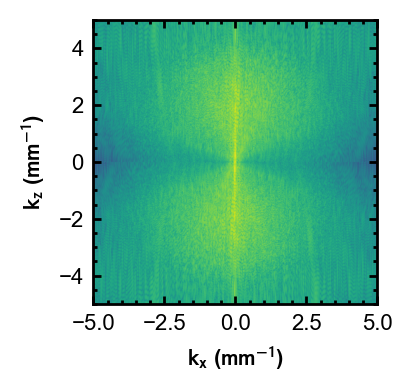

In [22]:
fig = plt.figure(figsize=(3, 2))
plt.imshow(np.log(np.abs(ft.T)), origin="lower", cmap="viridis", extent=(-5, 5) * 2)
plt.xlabel(r"$\mathbf{k_x}$ ($\mathbf{mm^{-1}}$)")
plt.ylabel(r"$\mathbf{k_z}$ ($\mathbf{mm^{-1}}$)")
plt.tight_layout()
plt.savefig("Illustration Figures/ft.png", dpi=300)
plt.savefig("Illustration Figures/ft.svg", dpi=300)
plt.show()